In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

Before I move on to model, I organized data. we will use ["Area..ABD.", "Area..Filled.", "Width", "Length", "Volume..ABD.", "Volume..ESD.", "Diameter..ABD.", "Diameter..ESD.", "Feret.Angle.Max", "Feret.Angle.Min", "Transparency", "Sum.Intensity", "Intensity", "Sigma.Intensity", "Edge.Gradient"] columns. Also we will focus on classifying 7 zooplanktons, which are ["Calanoid_1", "Cyclopoid_1", "Bosmina_1", "Herpacticoida", "Chironomid", "Chydoridae", "Daphnia"] therefore we assigned "Othres" if a zooplankton is not in the list. However to make good model it's important to reduce false positive, which incorrectly predicts a plankton as belonging to one of the selected classes when it actally belongs to "Others". For now we use base threshold but we can think of increase threshold later. 

In [5]:
# The dataframe is created by merging all CSV files
df = pd.read_csv(r'C:\Users\sprin\Downloads\SIMC_OverlapTiffsWithPP\SIMC_OverlapTiffsWithPP\SIMC.Overlap.csv\merged_data.csv')

feature_cols = [
    "Area..ABD.", "Area..Filled.", "Width", "Length", "Volume..ABD.", "Volume..ESD.", 
    "Diameter..ABD.", "Diameter..ESD.", "Feret.Angle.Max", "Feret.Angle.Min", "Symmetry", 
    "Circularity", "Convexity", "Aspect.Ratio", "Compactness", "Elongation", "Fiber.Curl", 
    "Fiber.Straightness", "Roughness", "Transparency", "Sum.Intensity", "Intensity", 
    "Sigma.Intensity", "Edge.Gradient"
]
target_col = "Class"

selected_classes = ["Calanoid_1", "Cyclopoid_1", "Bosmina_1", "Herpacticoida", "Chironomid", "Chydoridae", "Daphnia"]

# Exclude 'TooSmall' class from the dataframe
df = df[df[target_col] != 'TooSmall']
# Assign "Others" to all plankton not in selected_classes
df[target_col] = df[target_col].apply(lambda x: x if x in selected_classes else "Others")

In [6]:
class_proportions = df[target_col].value_counts(normalize=True)
print(class_proportions)

print("List of columns in the dataframe:")
print(df.columns.tolist())

Class
Calanoid_1       0.356176
Cyclopoid_1      0.327657
Others           0.309347
Bosmina_1        0.004758
Herpacticoida    0.001005
Daphnia          0.000923
Chydoridae       0.000071
Chironomid       0.000063
Name: proportion, dtype: float64
List of columns in the dataframe:
['Class.Particle.ID', 'Class', 'Area..ABD.', 'Area..Filled.', 'Aspect.Ratio', 'Calibration.Factor', 'Calibration.Image', 'Camera', 'Capture.X', 'Capture.Y', 'Circle.Fit', 'Circularity', 'Circularity..Hu.', 'Compactness', 'Convex.Perimeter', 'Convexity', 'Date', 'Diameter..ABD.', 'Diameter..ESD.', 'Diameter..FD.', 'Edge.Gradient', 'Elapsed.Time', 'Elongation', 'Feret.Angle.Max', 'Feret.Angle.Min', 'Fiber.Curl', 'Fiber.Straightness', 'Filter.Score', 'Geodesic.Aspect.Ratio', 'Geodesic.Length', 'Geodesic.Thickness', 'Image.File', 'Image.Height', 'Image.Width', 'Image.X', 'Image.Y', 'Intensity', 'Length', 'Original.Reference.ID', 'Particles.Per.Chain', 'Perimeter', 'Roughness', 'Sigma.Intensity', 'Source.Image', 'S

First, we will do logistic regression. 
We need some assumptions for logistic regression. First is that features needed to be linearly separable. Since features of zooplankton data are not separable but we will use logistic regression as a baseline. As logistic regression is simple and interpretable, as well as handle imbalanced classes well, I choose logistic regression with a baseline. 
Second is that there should be no multicolinearity. To remove multicolinearity, we will use PCA as EDA. To know how many principal components to take, I investigated scree plot. Based on scree plot, I decided to take 7 principal components. 
Third is that features are on the same scale however we found that range is extremely large. Therefore we will do log transformation as well as standardize the features. 
We apply log transformation since a lot of features are highly right skewed. Standardization alone doesn't fix skewness but centers the data around 0 and scale variance, log transformation will help to handle highly skewed distribution. 
I tried two standardize methods, which are standard scaling and robust scaling. Instead of standardize with mean and standard deviation, RobustSclaer() will standardize with median and IQR. That means, instead of $\frac{X-E[X]}{\sigma}$, we will use $\frac{X-\text{median}}{IQR}$. However, due to the dominance of "Others" class and "Others" calss have wide range of every features since we treat all zooplankton except for selected classes as others, its variance may still be too compressed and gave poor accuracy. Therefore we'll use standard scaling. 

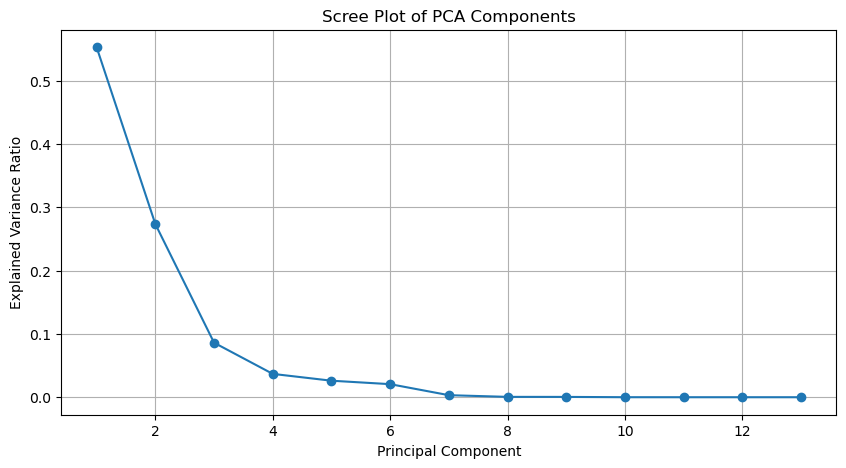

In [29]:
X = df[feature_cols]
y = df[target_col]

# drop Feret.Angle.Max and Feret.Angle.Min since they have negative values
X_log = X.drop(columns=["Feret.Angle.Max", "Feret.Angle.Min"]).apply(lambda x: np.log1p(x))

# Standardize features
scaler = StandardScaler()
# scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_log)

pca_full = PCA()
pca_full.fit(X_scaled)

# Explained variance ratio
explained_variance = pca_full.explained_variance_ratio_

# Plot Scree Plot
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='-')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot of PCA Components')
plt.grid(True)
plt.show()

In [ ]:
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=2453, stratify=y
)

# Logistic Regression
log_reg = LogisticRegression(class_weight="balanced", max_iter=1000)
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
                precision    recall  f1-score   support

    Bosmina_1       0.20      0.93      0.33       575
   Calanoid_1       0.82      0.40      0.54     43043
   Chironomid       0.00      0.62      0.00         8
   Chydoridae       0.00      0.50      0.00         8
  Cyclopoid_1       0.69      0.47      0.56     39596
      Daphnia       0.00      0.46      0.01       112
Herpacticoida       0.01      0.64      0.02       121
       Others       0.86      0.64      0.74     37384

     accuracy                           0.50    120847
    macro avg       0.32      0.58      0.27    120847
 weighted avg       0.78      0.50      0.60    120847

Confusion Matrix:
 [[  537     1     0    20     5     9     0     3]
 [  521 17198  3256  4904  5053  6652  2488  2971]
 [    0     0     5     0     1     1     1     0]
 [    2     0     0     4     1     0     1     0]
 [  557  1900  3677  5925 18674  2165  5668  1030]
 [    1    15     6    10    20    52  

Since the accuracy is not as I want, I'll use XGBoost. 
Assumption: 
Reason:
When we do XGBoost, we'll train with selected classes and not with Others. Instead, we will classify a plankton with others when the prediction probability is less than threshold we set. 

In [ ]:
# # XGBoost Model with Hyperparameter Tuning
# param_dist = {
#     "n_estimators": [100, 200, 300],
#     "max_depth": [3, 5, 7],
#     "learning_rate": [0.01, 0.05, 0.1],
#     "subsample": [0.7, 0.8, 1.0],
#     "colsample_bytree": [0.7, 0.8, 1.0]
# }

# xgb_clf = XGBClassifier(eval_metric="mlogloss", random_state=2453)

# # Randomized Search for Hyperparameter Optimization
# random_search = RandomizedSearchCV(
#     xgb_clf, param_distributions=param_dist, 
#     n_iter=20, scoring="f1_weighted", cv=5, verbose=1, n_jobs=-1
# )

# random_search.fit(X_train, y_train)

# # Best model
# best_xgb = random_search.best_estimator_

# # Cross-validation to evaluate model
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2453)
# scores = cross_val_score(best_xgb, X_train, y_train, cv=cv, scoring="f1_weighted")
# print(f"Cross-validation F1-score: {np.mean(scores):.4f}")

# # Model evaluation using probability threshold
# y_prob = best_xgb.predict_proba(X_test)
# threshold = 0.7  # Define probability threshold
# max_probs = np.max(y_prob, axis=1)
# y_pred_indices = np.argmax(y_prob, axis=1)
# y_pred = label_encoder.inverse_transform(y_pred_indices)  # Convert back to class names

# y_pred[max_probs < threshold] = "Others"

# print("Final Predictions:")
# print(y_pred)

# print("Classification Report:")
# print(classification_report(label_encoder.inverse_transform(y_test), y_pred))
# print("Confusion Matrix:")
# print(confusion_matrix(label_encoder.inverse_transform(y_test), y_pred))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Cross-validation F1-score: 0.8943
Final Predictions:
['Cyclopoid_1' 'Calanoid_1' 'Cyclopoid_1' ... 'Others' 'Calanoid_1'
 'Cyclopoid_1']
Classification Report:


c:\Users\sprin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sprin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sprin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sprin\anaconda3\Lib\site-packages\sklea

               precision    recall  f1-score   support

    Bosmina_1       0.95      0.75      0.84       575
   Calanoid_1       0.94      0.83      0.88     43043
   Chironomid       1.00      0.14      0.25         7
   Chydoridae       0.00      0.00      0.00         9
  Cyclopoid_1       0.94      0.81      0.87     39597
      Daphnia       1.00      0.11      0.19       112
Herpacticoida       0.69      0.07      0.13       121
       Others       0.00      0.00      0.00         0

     accuracy                           0.82     83464
    macro avg       0.69      0.34      0.40     83464
 weighted avg       0.94      0.82      0.87     83464

Confusion Matrix:
[[  433    38     0     0    10     0     0    94]
 [   15 35606     0     0  1972     0     1  5449]
 [    0     1     1     0     3     0     0     2]
 [    0     3     0     0     2     0     0     4]
 [    9  2236     0     0 32121     0     3  5228]
 [    0    45     0     0    17    12     0    38]
 [    0    16

c:\Users\sprin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sprin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# # XGBoost Model with sample weights
# sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)

# xgb_clf = XGBClassifier(
#     eval_metric="mlogloss",
#     random_state=2453
# )

# # Randomized Search for Hyperparameter Optimization
# random_search = RandomizedSearchCV(
#     xgb_clf, param_distributions=param_dist, 
#     n_iter=20, scoring="f1_weighted", cv=5, verbose=1, n_jobs=-1
# )

# random_search.fit(X_train, y_train, sample_weight = sample_weights)

# # Best model
# best_xgb = random_search.best_estimator_

# # Cross-validation to evaluate model
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2453)
# scores = cross_val_score(best_xgb, X_train, y_train, cv=cv, scoring="f1_weighted")
# print(f"Cross-validation F1-score: {np.mean(scores):.4f}")

# # Model evaluation using probability threshold
# y_prob = best_xgb.predict_proba(X_test)
# threshold = 0.7  # Define probability threshold
# max_probs = np.max(y_prob, axis=1)
# y_pred_indices = np.argmax(y_prob, axis=1)
# y_pred = label_encoder.inverse_transform(y_pred_indices)  # Convert back to class names

# y_pred[max_probs < threshold] = "Others"

# print("Final Predictions:")
# print(y_pred)

# print("Classification Report:")
# print(classification_report(label_encoder.inverse_transform(y_test), y_pred))
# print("Confusion Matrix:")
# print(confusion_matrix(label_encoder.inverse_transform(y_test), y_pred))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Cross-validation F1-score: 0.8969
Final Predictions:
['Cyclopoid_1' 'Calanoid_1' 'Cyclopoid_1' ... 'Others' 'Calanoid_1'
 'Cyclopoid_1']
Classification Report:


c:\Users\sprin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sprin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sprin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sprin\anaconda3\Lib\site-packages\sklea

               precision    recall  f1-score   support

    Bosmina_1       0.72      0.91      0.80       575
   Calanoid_1       0.95      0.79      0.86     43043
   Chironomid       0.33      0.14      0.20         7
   Chydoridae       0.00      0.00      0.00         9
  Cyclopoid_1       0.94      0.79      0.86     39597
      Daphnia       0.23      0.28      0.25       112
Herpacticoida       0.20      0.41      0.27       121
       Others       0.00      0.00      0.00         0

     accuracy                           0.79     83464
    macro avg       0.42      0.41      0.41     83464
 weighted avg       0.94      0.79      0.86     83464

Confusion Matrix:
[[  521    14     0     0     3     2     0    35]
 [  111 33965     1     0  1927    84    39  6916]
 [    0     1     1     0     2     0     2     1]
 [    1     3     0     0     1     1     1     2]
 [   86  1914     1     0 31340    18   159  6079]
 [    2    32     0     0    10    31     0    37]
 [    0    10

c:\Users\sprin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sprin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# # XGBoost Model with SMOTE
# smote = SMOTE(random_state=2453)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# # XGBoost Model with Hyperparameter Tuning
# param_dist = {
#     "n_estimators": [100, 200, 300],
#     "max_depth": [3, 5, 7],
#     "learning_rate": [0.01, 0.05, 0.1],
#     "subsample": [0.7, 0.8, 1.0],
#     "colsample_bytree": [0.7, 0.8, 1.0]
# }

# xgb_clf = XGBClassifier(eval_metric="mlogloss", random_state=2453)

# # Randomized Search for Hyperparameter Optimization
# random_search = RandomizedSearchCV(
#     xgb_clf, param_distributions=param_dist, 
#     n_iter=20, scoring="f1_weighted", cv=5, verbose=1, n_jobs=-1
# )

# random_search.fit(X_train_resampled, y_train_resampled)

# # Best model
# best_xgb = random_search.best_estimator_

# # Cross-validation to evaluate model
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2453)
# scores = cross_val_score(best_xgb, X_train_resampled, y_train_resampled, cv=cv, scoring="f1_weighted")
# print(f"Cross-validation F1-score: {np.mean(scores):.4f}")

# # Model evaluation using probability threshold
# y_prob = best_xgb.predict_proba(X_test)
# threshold = 0.7  # Define probability threshold
# max_probs = np.max(y_prob, axis=1)
# y_pred_indices = np.argmax(y_prob, axis=1)
# y_pred = label_encoder.inverse_transform(y_pred_indices)  # Convert back to class names

# y_pred[max_probs < threshold] = "Others"

# print("Final Predictions:")
# print(y_pred)

# print("Classification Report:")
# print(classification_report(label_encoder.inverse_transform(y_test), y_pred))
# print("Confusion Matrix:")
# print(confusion_matrix(label_encoder.inverse_transform(y_test), y_pred))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Cross-validation F1-score: 0.9467
Final Predictions:
['Cyclopoid_1' 'Calanoid_1' 'Cyclopoid_1' ... 'Others' 'Calanoid_1'
 'Others']
Classification Report:


c:\Users\sprin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sprin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


               precision    recall  f1-score   support

    Bosmina_1       0.67      0.91      0.77       575
   Calanoid_1       0.96      0.71      0.82     43043
   Chironomid       0.04      0.29      0.08         7
   Chydoridae       0.00      0.00      0.00         9
  Cyclopoid_1       0.95      0.70      0.81     39597
      Daphnia       0.08      0.38      0.13       112
Herpacticoida       0.10      0.49      0.16       121
       Others       0.00      0.00      0.00         0

     accuracy                           0.71     83464
    macro avg       0.35      0.44      0.35     83464
 weighted avg       0.95      0.71      0.81     83464

Confusion Matrix:
[[  523     6     0     0     2     2     0    42]
 [  134 30675    19   111  1432   329   140 10203]
 [    0     1     2     0     1     0     2     1]
 [    1     3     0     0     0     1     1     3]
 [  119  1402    25    89 27772   170   415  9605]
 [    2    20     0     2     4    43     0    41]
 [    0     8

c:\Users\sprin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
